# Load and View Data

Number of data points: 200
k in [0, 199]


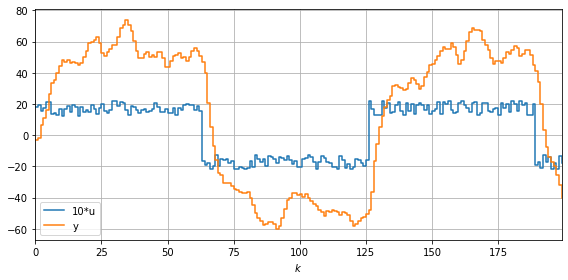

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
data = pd.read_csv(file, header=None, names=['u', 'y'])
N = len(data)

k = data.index.values
u = data.u.values
y = data.y.values

print('Number of data points:', N)
print(f'k in [{k[0]}, {k[-1]}]')

plt.figure(figsize=(8,4))
plt.plot(k, 10*u, label='10*u', drawstyle='steps-post')
plt.plot(k, y   , label='y'   , drawstyle='steps-post')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Input Fourier Transform

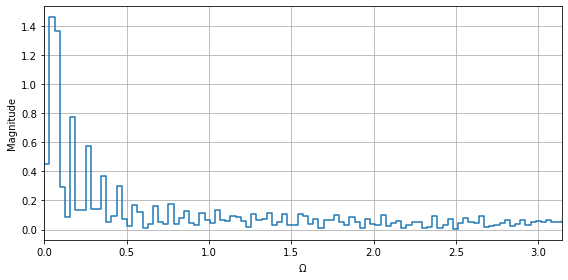

In [10]:
from scipy import fft

u_rfft = fft.rfft(u, norm='forward')
u_rfft[1:-1] = 2*u_rfft[1:-1]

u_rfft_mag = np.abs(u_rfft)
Omega = np.linspace(0, np.pi, len(u_rfft_mag))

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xlim(Omega[0], Omega[-1])
plt.xlabel(r'$\Omega$')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

## Separate Identification and Validation Data

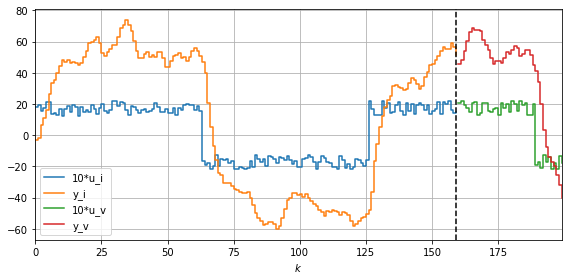

In [11]:
N_fold = 160

k_i = k[:N_fold]
u_i = u[:N_fold]
y_i = y[:N_fold]

k_v = k[N_fold:]
u_v = u[N_fold:]
y_v = y[N_fold:]

plt.figure(figsize=(8,4))
plt.plot(k_i, 10*u_i, label='10*u_i', drawstyle='steps-post')
plt.plot(k_i, y_i   , label='y_i'   , drawstyle='steps-post')
plt.plot(k_v, 10*u_v, label='10*u_v', drawstyle='steps-post')
plt.plot(k_v, y_v   , label='y_v'   , drawstyle='steps-post')
plt.axvline(k[N_fold-1], color='black', linestyle='--')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Generic Model

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [12]:
from functions import models_frame

models = models_frame()

# ARX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\end{gather*}

In [13]:
from functions import arx

na_range = range(1, 3 + 1)
nb_range = range(1, 3 + 1)
nk_range = range(0, 2 + 1)

models_arx = arx(u_i, y_i, u_v, y_v, na_range, nb_range, nk_range)

models = pd.concat([models, models_arx], ignore_index=True)

# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

In [14]:
from functions import armax

na_range = range(1, 3 + 1)
nb_range = range(1, 3 + 1)
nc_range = range(0, 3 + 1)
nk_range = range(0, 2 + 1)

models_armax = armax(u_i, y_i, u_v, y_v, na_range, nb_range, nc_range, nk_range)

models = pd.concat([models, models_armax], ignore_index=True)

# Output Error

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [15]:
from functions import oe

nb_range = range(1, 3 + 1)
nf_range = range(1, 3 + 1)
nk_range = range(0, 2 + 1)

models_oe = oe(u_i, y_i, u_v, y_v, nb_range, nf_range, nk_range)

models = pd.concat([models, models_oe], ignore_index=True)

# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [16]:
from functions import bj

nb_range = range(1, 3 + 1)
nc_range = range(0, 3 + 1)
nd_range = range(1, 3 + 1)
nf_range = range(1, 3 + 1)
nk_range = range(0, 2 + 1)

models_bj = bj(u_i, y_i, u_v, y_v, nb_range, nc_range, nd_range, nf_range, nk_range)

models = pd.concat([models, models_bj], ignore_index=True)

d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value